In [1]:
import sqlalchemy
from sqlalchemy import create_engine, text, func, inspect
from sqlalchemy import Column, Integer, String, Float
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pprint

In [2]:
# Setting up an engine connection dependencies
username = 'postgres'
hostname = 'localhost' 
password = 'postgres16'
port = '5434' 
database_name = 'Project_3_'

# Creating a connection string
connection_string = f'postgresql://{username}:{password}@{hostname}:{port}/{database_name}'

# Creating an engine
engine = create_engine(connection_string)

# Testing the connection
try:
    with engine.connect():
        print("Connection successful!")
except Exception as e:
    print(f"Connection failed! Error: {str(e)}")

Connection successful!


In [3]:
# This is the Database being used
clean_table = pd.read_sql('select * from clean_table', engine)
clean_table

,Participant ID,Age (Years),Gender,Exercise Type (4 and 9),Exercise Intensity,Exercise Duration (Minute),Calories Burnt (Cal),Calories Burnt (60 min),Heart Rate (BPM),BMI,Recorded Weight (Kg),Dream Weight (Kg)
0,3,20,0,4,4,20,261.22,783.66,148,27.90,71,70
1,7,18,0,9,10,53,457.63,518.07,103,34.59,61,65
2,8,42,0,4,2,25,272.96,655.10,104,22.05,62,64
3,20,49,0,9,8,59,103.34,105.09,149,20.45,84,88
4,22,29,0,9,2,37,131.46,213.18,135,20.54,52,54
...,...,...,...,...,...,...,...,...,...,...,...,...
760,3850,56,0,9,3,54,113.94,126.60,102,31.93,67,68
761,3853,37,1,9,3,35,132.48,227.11,178,28.65,66,64
762,3861,21,1,4,5,49,486.39,595.58,160,26.60,92,97
763,3862,57,0,4,9,56,264.31,283.19,167,31.44,96,94


In [4]:
## FUNCTION FOR USER_INTERFACE
def access_database():
    # Get column names from the specified table
    inspector = inspect(engine)
    columns = inspector.get_columns('clean_table')
    column_names = [column['name'] for column in columns]
    table_name = 'clean_table'

    # Display the database info
    print("[Top Exercises for Burning Calories]")
    print("Available columns:")
    for i, column_name in enumerate(column_names):
        print(f"{i + 1}. {column_name}")

    # Prompt the user to select columns
    selected_columns = input("Enter column numbers separated by commas (e.g., 1, 3, 5) or type 'all' for all columns: ").strip().lower()
    print (f"you have chosen: {selected_columns}")
    selected_columns = '*' if selected_columns == 'all' else ', '.join([f'"{column_names[int(index) - 1]}"' for index in selected_columns.split(',')])
    # Prompt the user to select sorting method
    sort_by_column = input("Enter column number to sort by (leave blank for no sorting): ").strip().lower()
    if sort_by_column:
        sort_by_column = f'"{column_names[int(sort_by_column) - 1]}"'
        sort_order = input("Enter 'asc' for ascending or 'desc' for descending: ").strip().lower()
        if sort_order == 'desc':
            sort_by_column += " DESC"
        elif sort_order != 'asc':
            print("Invalid input for sort order. Defaulting to ascending.")
    # Prompt the user to select row limit
    row_limit = input("Enter the number of rows to display (or type 'all' for all rows): ").strip().lower()
    row_limit = '' if row_limit == 'all' else f"LIMIT {int(row_limit)}"
    # Perform query based on user input
    query = f"SELECT {selected_columns} FROM {table_name}"
    if sort_by_column:
        query += f" ORDER BY {sort_by_column}"
    query += f" {row_limit}"

    # Execute the query and load the results into a DataFrame
    new_table = pd.read_sql(query, engine)
    if 'Gender' in new_table.columns:
        gender_mapping = {1:'F',0:'M'}
        new_table['Gender'] = new_table['Gender'].map(gender_mapping)
    print (new_table)

    # Prompt the user to save table as csv file
    save = input("Enter 'yes' or 'no' if you would like to save the table to .csv file?").strip().lower()
    if save == 'yes':
        # Define the output folder 
        file_name = input ("Enter file name ")
        output_folder = 'output_folder'
        # Create the folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        #save the table to csv file
        new_table.to_csv(os.path.join(output_folder,f'{file_name}.csv'), index=False)
        print(f"This dataframe has been saved in output_folder as {file_name}")
    
    # Prompt user to load table into SQL        
    load = input ("Enter 'yes' or 'no' if you would like to load the table to PostgresSQL?").strip().lower()
    # Loading final table to the SQL database engine and replacing if it already exists.
    if load == 'yes':
        table_name = input ("Enter table name ")
        new_table.to_sql(table_name, engine, if_exists="replace")
        print(f"This dataframe has been loaded to PostgresSQL in {database_name} as {table_name}")
    
    # Prompt user to see our analysis
    analysis = input("Enter 'yes' or 'no' if you would like to see some of our analysis ")
    if analysis == 'yes':
        # Create a scatter plot with seaborn for exercise 4 & 9 for each gender
        clean_table = pd.read_sql('select * from clean_table', engine)
        gender_mapping = {1:'F',0:'M'}
        clean_table['Gender'] = clean_table['Gender'].map(gender_mapping)
        fig, ax = plt.subplots()
        sns.scatterplot(data=clean_table, y='Calories Burnt (60 min)', x='Gender', hue='Exercise Type (4 and 9)', style='Gender', markers=['o', 's'])
        ax.set_title('Calories burnt in 60mins for Male and Female in each exercise')
        plt.show()
        print ("This plot is created with the library - seaborn")
    # Prompt user to save the plot 
        saveplot = input("Enter 'yes' or 'no' if you would like to save this plot ")
        if saveplot == 'yes':
            output_folder = 'output_folder'
            # Create the folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
            fig.savefig(os.path.join(output_folder,'seaborn_plot.png'))
            print ('This plot has been saved in output_folder as seaborn_plot')

    return "Thanks for using :)"

[Top Exercises for Burning Calories]
Available columns:
1. Participant ID
2. Age (Years)
3. Gender
4. Exercise Type (4 and 9)
5. Exercise Intensity
6. Exercise Duration (Minute)
7. Calories Burnt (Cal)
8. Calories Burnt (60 min)
9. Heart Rate (BPM)
10. BMI
11. Recorded Weight (Kg)
12. Dream Weight (Kg)
you have chosen: 2, 5, 10
    Age (Years) Exercise Intensity    BMI
0            18                  9  20.01
1            18                  7  34.68
2            18                  3  20.33
3            18                  6  29.53
4            18                  1  31.49
5            18                  9  20.50
6            18                  1  31.76
7            18                  4  33.82
8            18                  6  32.56
9            18                  8  34.12
10           18                  4  34.93
11           18                  2  19.88
12           18                  4  28.68
13           18                  3  31.56
14           18                 10  34.5

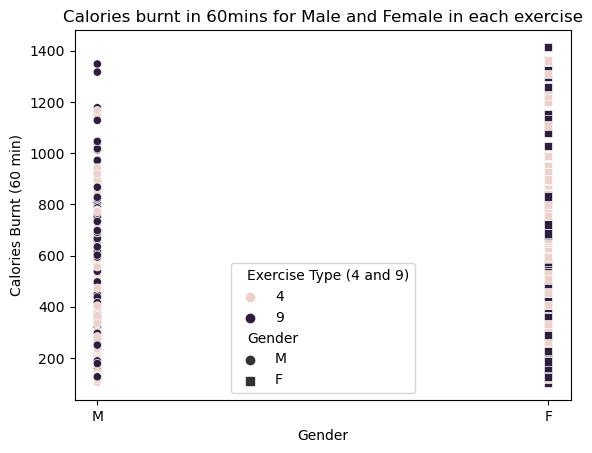

This plot is created with the library - seaborn
This plot has been saved in output_folder as seaborn_plot


'Thanks for using :)'

In [6]:
## EXECUTE FUNCITON: access_database()
access_database()